<a href="https://colab.research.google.com/github/MrBenjaminHolmes/Gravitational-Waves/blob/main/GWChallenges.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Gravitational Wave Open Data Challenges

In [3]:
!pip install -q lalsuite==7.25 scipy==1.12.0 gwpy==3.0.12 bilby==2.4.0 matplotlib==3.10.0 dynesty==2.1.5 corner==2.2.3 numpy==1.26.4 PyCBC==2.4.1

In [4]:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")

from IPython.utils import io
import matplotlib.pyplot as plt
import numpy
import os
import urllib
import h5py
import pandas as pd
import logging
logging.getLogger('bilby').setLevel(logging.ERROR)
import corner
import astropy.units as u
from astropy.cosmology import Planck15, z_at_value

#Bilby
import bilby
from bilby.core.prior import Uniform, PowerLaw
from bilby.core.utils import SamplesSummary
from bilby.gw.conversion import convert_to_lal_binary_black_hole_parameters, generate_all_bbh_parameters

# GW
import gwpy
from gwpy.timeseries import TimeSeries
from gwosc.datasets import event_gps
from gwpy.signal import qtransform

# PyCBC
import pycbc
import pycbc.noise
import pycbc.psd
from pycbc.catalog import Merger
from pycbc.detector import Detector
from pycbc.events.ranking import newsnr
from pycbc.filter import (
    highpass,
    matched_filter,
    resample_to_delta_t,
    sigma
)
from pycbc.vetoes import power_chisq
from pycbc.frame import read_frame
from pycbc.psd import interpolate, inverse_spectrum_truncation
from pycbc.waveform import (
    fd_approximants,
    get_td_waveform,
    get_fd_waveform,
    td_approximants
)

# Challenge 1


Identify a loud binary black hole signal in white, Gaussian noise.

* Use the data file `challenge1.gwf`. The channel name is `H1:CHALLENGE1`.
* The data are white, Gaussian noise containing a simulated BBH signal.

1. Load the data into memory. What are the sampling rate and duration of the data?
2. Plot the data in the time-domain.
3. Plot a spectrogram (or q-transform) of the data, and try to identify the signal.
4. What is the time of the merger?


Getting: https://raw.githubusercontent.com/MrBenjaminHolmes/Gravitational-Waves/main/SampleData/challengeData/challenge1.gwf
Sampling rate: 4096.0 Hz
Duration: 128.0 seconds


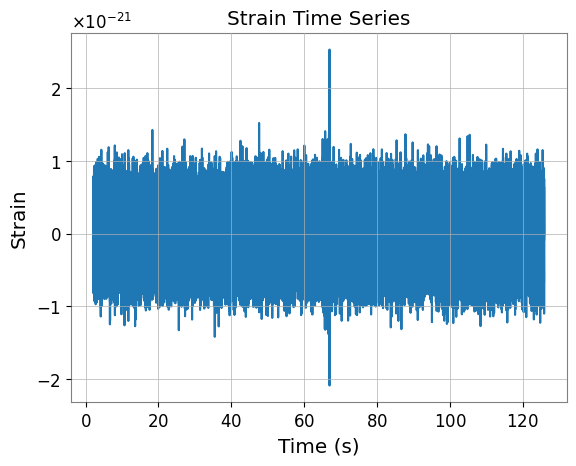

In [13]:
def get_file(fname):
    url = f"https://raw.githubusercontent.com/MrBenjaminHolmes/Gravitational-Waves/main/SampleData/challengeData/{fname}"
    urllib.request.urlretrieve(url, fname)
    print(f'Getting: {url}')

file_name = 'challenge1.gwf'
channel_name = "H1:CHALLENGE1"
start = 0
end = start + 128

get_file(file_name)


# Load and preprocess strain
ts = read_frame(file_name, channel_name, start, end)

sampling_rate = 1.0 / ts.delta_t
print(f"Sampling rate: {sampling_rate} Hz")

duration = ts.duration  # in seconds
print(f"Duration: {duration} seconds")

ts = ts.highpass_fir(15, 512)
ts = resample_to_delta_t(ts, 1.0/2048).crop(2, 2)

plt.figure()
plt.plot(ts.sample_times, ts.data)
plt.xlabel("Time (s)")
plt.ylabel("Strain")
plt.title("Strain Time Series")
plt.show()


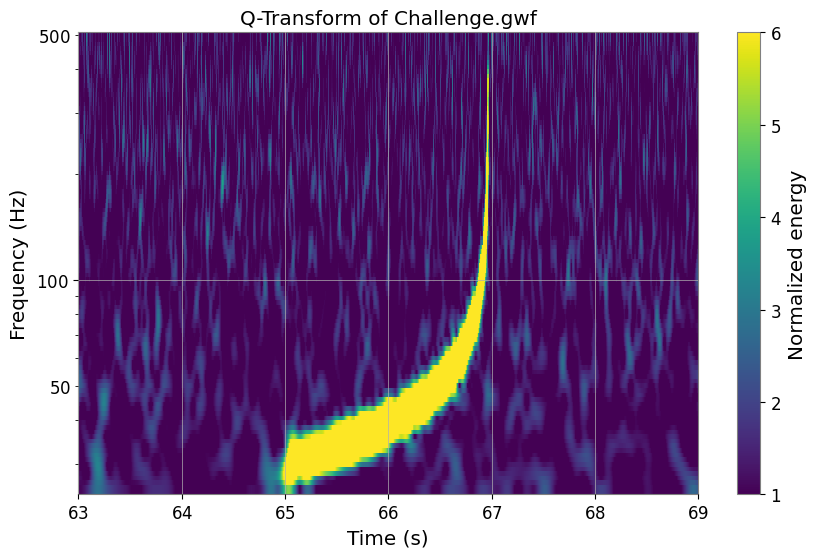

In [16]:
time, frequency, power = ts.whiten(4, 4).qtransform(.001, logfsteps=100, qrange=(4, 20), frange=(25, 500))
power_sqrt = power**0.5

plt.figure(figsize=(10, 6))
plt.pcolormesh(time, frequency, power_sqrt, vmin=1, vmax=6, shading = "auto")
plt.yscale('log')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Q-Transform of Challenge.gwf')
plt.xlim(65-2,65+4)
plt.colorbar(label='Normalized energy')
plt.show()

##Challenge 2

Signal in colored, Gaussian noise.

* Use the data file `challenge2.gwf`, with channel name `H1:CHALLENGE2`.
* The data contain a BBH signal with m1 = m2 = 30 solar masses, spin = 0.

1. What is the approximative time of the merger? (Hint: a plot of the q-transform could help)
2. Generate a time-domain template waveform using approximate `SEOBNRv4_opt`.
   with the same parameters as above. Plot this waveform.
3. Calculate a PSD of the data, and plot this on a log-log scale.
   Use axes ranging from 20 Hz up to the Nyquist frequency.
4. Use the template waveform and PSD to calculate the SNR time series. Plot the SNR time-series.
5. What is the matched filter SNR of the signal?